<a href="https://colab.research.google.com/github/tuliofalmeida/pyjama/blob/main/PyJama_JAMA_practical_test_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PyJama - Python for Joint Angle Measurement Acquisition Library
## Knee joint during gait example

Joint angle measure using PyJama and JAMA

This notebook uses an open source project [tuliofalmeida/pyjama](https://pypi.org/project/pyjamalib/) to estimate knee angle using IMU data and video.

In this notebook we use [JAMA - Joint Angle Measurement Acquisition Device]((https://github.com/tuliofalmeida/jama)), an open access hardware for measuring joint angles. We use JAMA to assess the knee of a person in a real situation, in order to validate the developed device and the PyJama. In order to compare the findings, we film and extracted the angle using the [Kinovea](https://www.kinovea.org/) software. The objective was to evaluate the flexion and extension behavior of the knee joint, so the sensors were placed on the individual's thigh and shin.

JAMA aquisition parameters:
*   Frequency: 75 Hz
*   Aquisition duration: 120s

Video details: 
*   Duration: 00:01:50
*   FPS: 30

For other examples and details about the library, visit [Pyjama GitHub](https://github.com/tuliofalmeida/pyjama).

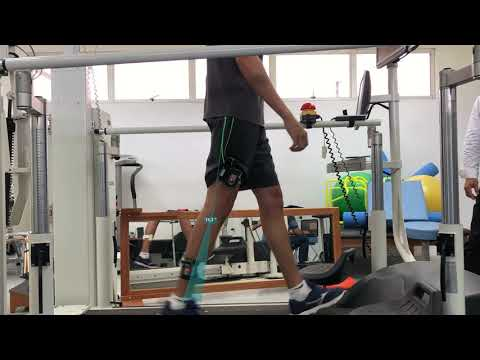

In [22]:
#@title Data collection video
from IPython.display import YouTubeVideo
YouTubeVideo('0f4hjDHrdug',width=640, height=480)

## (1) Import libraries 

In [1]:
!pip install pyjamalib 

     |████████████████████████████████| 71kB 4.0MB/s 


In [2]:
!git clone https://github.com/tuliofalmeida/pyjama

Cloning into 'pyjama'...
remote: Enumerating objects: 654, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 654 (delta 14), reused 27 (delta 6), pack-reused 609
Receiving objects: 100% (654/654), 36.58 MiB | 29.10 MiB/s, done.
Resolving deltas: 100% (364/364), done.


In [3]:
import pyjamalib as pjl
import pandas as pd
import numpy as np

## (2) Loading the data

In [4]:
path = '/content/pyjama/docs/gait jama/Gait JAMA.txt'
data = pjl.DataHandler.import_raw_data(path)
path_calib = '/content/pyjama/docs/gait jama/Calib data.txt'
data_calib = pjl.DataHandler.import_raw_data(path_calib)
path_kinovea = '/content/pyjama/docs/gait jama/gait_jama_kinovea.csv'
kinovea = pd.read_csv(path_kinovea,delimiter=';')

In [5]:
thigh_data = pjl.DataHandler.split_raw_data(data[6])
thigh_calibration = pjl.DataHandler.split_raw_data(data_calib[6])
shin_data = pjl.DataHandler.split_raw_data(data[5])
shin_calibration = pjl.DataHandler.split_raw_data(data_calib[5])

## (3) Data Calibration and DataFrame creation

In [6]:
thigh_df = pjl.DataHandler.toDataframe(thigh_data,thigh_calibration)
shin_df = pjl.DataHandler.toDataframe(shin_data,shin_calibration)

# Grouping thigh data into matrices
acc_thigh = pjl.DataHandler.csvFloatMerge(thigh_df['Acc_X'],
                                          thigh_df['Acc_Y'],
                                          thigh_df['Acc_Z'])
gyr_thigh = pjl.DataHandler.csvFloatMerge(thigh_df['Gyr_X'],
                                          thigh_df['Gyr_Y'],
                                          thigh_df['Gyr_Z'])
mag_thigh = pjl.DataHandler.csvFloatMerge(thigh_df['Mag_X'],
                                          thigh_df['Mag_Y'],
                                          thigh_df['Mag_Z'])

# Grouping shin data into matrices
acc_shin = pjl.DataHandler.csvFloatMerge(shin_df['Acc_X'],
                                         shin_df['Acc_Y'],
                                         shin_df['Acc_Z'])   
gyr_shin = pjl.DataHandler.csvFloatMerge(shin_df['Gyr_X'],
                                         shin_df['Gyr_Y'],
                                         shin_df['Gyr_Z'])
mag_shin = pjl.DataHandler.csvFloatMerge(shin_df['Mag_X'],
                                         shin_df['Mag_Y'],
                                         shin_df['Mag_Z'])

# Creating matrices of Kinovea data
data_kinovea = np.asarray([float(kinovea['Knee Angle'][i].replace(',', '.'))                        for i in range(len(kinovea['Knee Angle']))])

## (4) Data filtering 


In [7]:
mad_acc_thigh = pjl.DataProcessing.low_pass_filter(acc_thigh[1050:7000],0.05)
mad_gyr_thigh = pjl.DataProcessing.low_pass_filter(gyr_thigh[1050:7000],0.4)
mad_mag_thigh = pjl.DataProcessing.low_pass_filter(mag_thigh[1050:7000],0.05)
mad_acc_shin  = pjl.DataProcessing.low_pass_filter(acc_shin[1050:7000],0.05)
mad_gyr_shin  = pjl.DataProcessing.low_pass_filter(gyr_shin[1050:7000],0.4)
mad_mag_shin  = pjl.DataProcessing.low_pass_filter(mag_shin[1050:7000],0.05)

## (5) Data fusion

In [8]:
mad_thigh = pjl.DataProcessing.MadgwickAHRS(mad_acc_thigh,
                                            mad_gyr_thigh,
                                            mad_mag_thigh,
                                            freq=75,
                                            beta1=.01,
                                            beta2=1)

mad_shin = pjl.DataProcessing.MadgwickAHRS(mad_acc_shin,
                                           mad_gyr_shin,
                                           mad_mag_shin,
                                           freq=75,
                                           beta1=.01,
                                           beta2=1)

## (6) Joint angle calculation 

In [9]:
madX = [180-(mad_thigh[i,0] + mad_shin[i,0]) for i in range(len(mad_shin))]
madY = [180-(mad_thigh[i,1] + mad_shin[i,1]) for i in range(len(mad_shin))]
madZ = [180-(mad_thigh[i,2] + mad_shin[i,2]) for i in range(len(mad_shin))]

## (7) Data adjustments 

In [10]:
df = pd.DataFrame({'dataX':abs(np.asarray(madX[100:])-23),
                   'dataY':np.asarray(madY[100:])-180,
                   'dataZ':np.asarray(madZ[100:])+155})

## (8) Extraction of gait cycles 

In [11]:
# Time
time_stamp = thigh_df['Time'][500:7000]
time_kinovea = np.arange(0, len(data_kinovea)/30, 1/30)

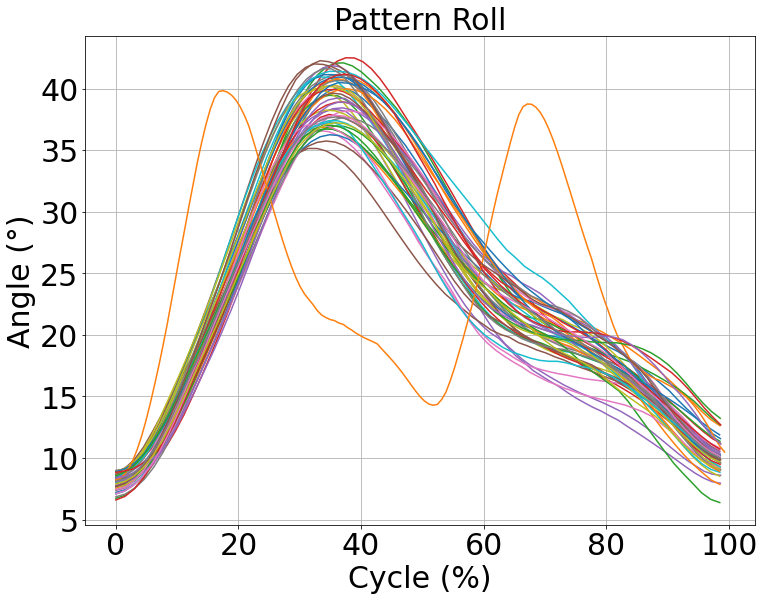

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [12]:
# Roll
patternX,romX = pjl.DataProcessing.pattern_extraction(df['dataX'][500:],
                                                      time_stamp,
                                                      threshold=9,
                                                      bias=1,
                                                      title = 'Pattern Roll',
                                                      plot=True)

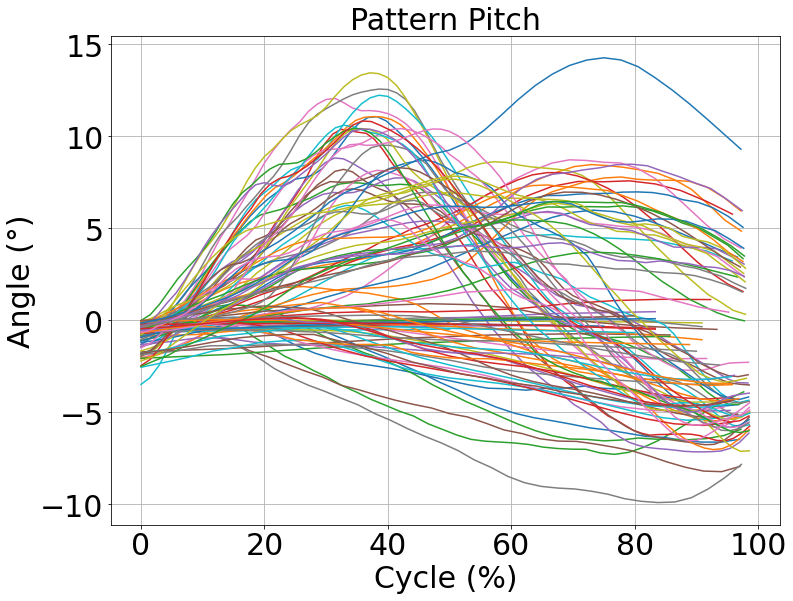

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [13]:
# Pitch                                                     
patternY,romY = pjl.DataProcessing.pattern_extraction(df['dataY'][500:],
                                                      time_stamp,
                                                      threshold=0,
                                                      bias=1,
                                                      title = 'Pattern Pitch',
                                                      plot=True)

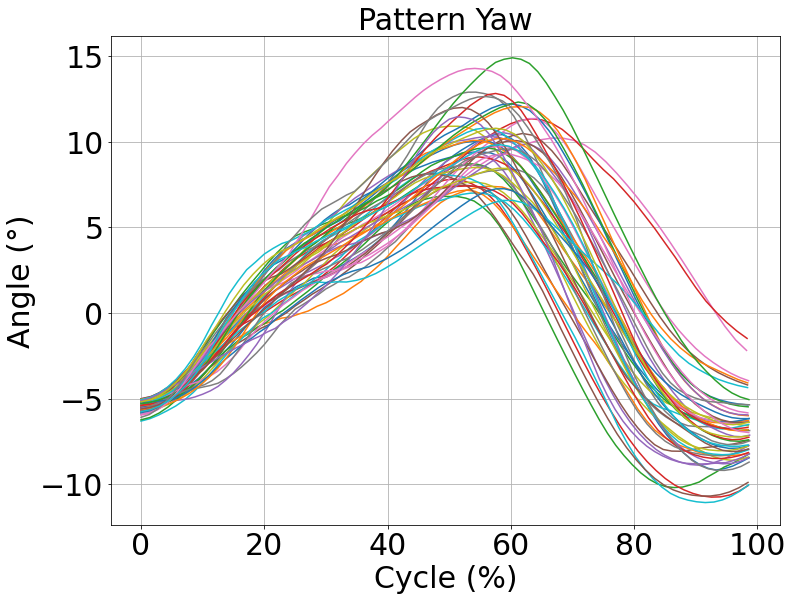

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [14]:
# Yaw
patternZ,romZ = pjl.DataProcessing.pattern_extraction(df['dataZ'][500:],
                                                      time_stamp,
                                                      threshold=-5,
                                                      bias=0,
                                                      title = 'Pattern Yaw',
                                                      plot=True)

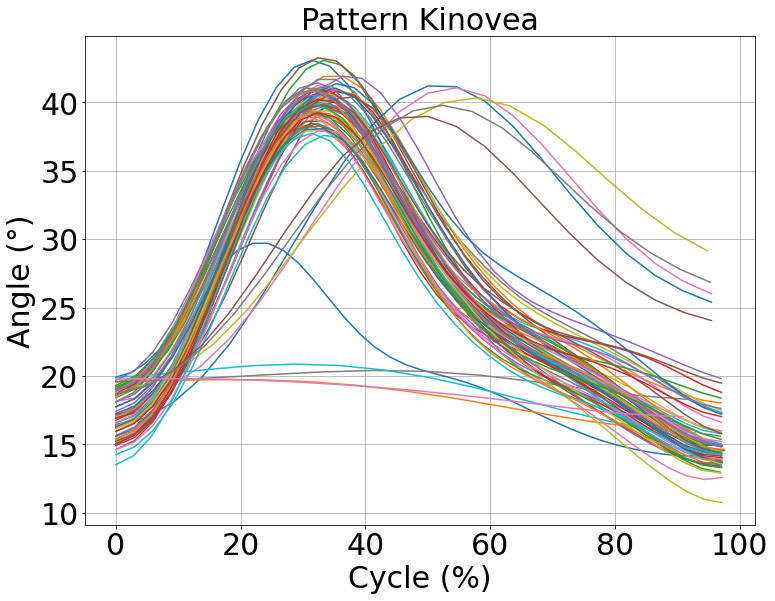

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [15]:
# Kinovea
patternK,romK = pjl.DataProcessing.pattern_extraction(data_kinovea,
                                                      time_kinovea,
                                                      threshold=20,
                                                      bias =0,
                                                      df=False,
                                                      title = 'Pattern Kinovea',
                                                      plot=True)

## (9) Average of cycles 

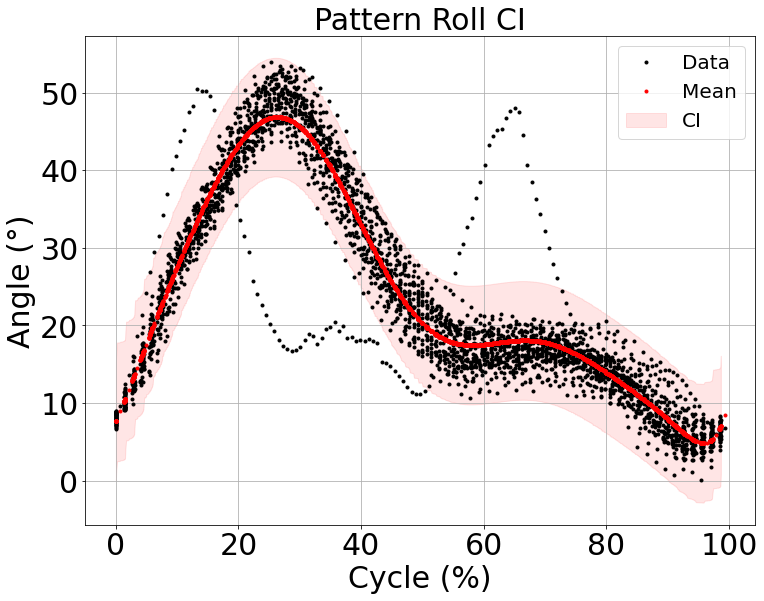

In [16]:
# Roll
patternX_IC = pjl.DataProcessing.patternCI(patternX[:,0],
                                           patternX[:,1],
                                           poly_degree = 10,
                                           title = 'Pattern Roll CI',
                                           label1 = 'Data',
                                           label2 = 'Mean',
                                           df = False,
                                           plot = True)

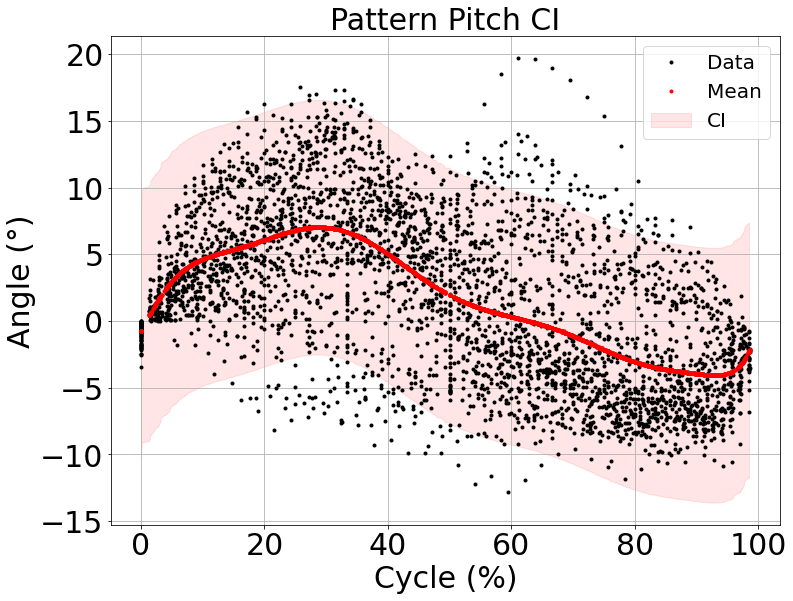

In [17]:
# Pitch
patternY_IC = pjl.DataProcessing.patternCI(patternY[:,0],
                                           patternY[:,1],
                                           poly_degree = 10,
                                           title = 'Pattern Pitch CI',
                                           label1 = 'Data',
                                           label2 = 'Mean',
                                           df = False,
                                           plot = True)

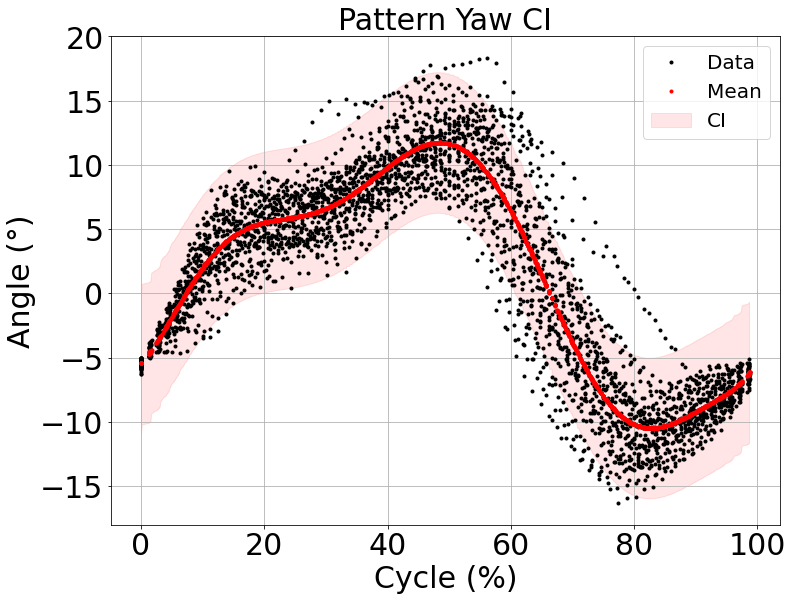

In [18]:
# Yaw
patternZ_IC = pjl.DataProcessing.patternCI(patternZ[:,0],
                                           patternZ[:,1],
                                           poly_degree = 10,
                                           title = 'Pattern Yaw CI',
                                           label1 = 'Data',
                                           label2 = 'Mean',
                                           df = False,
                                           plot = True)

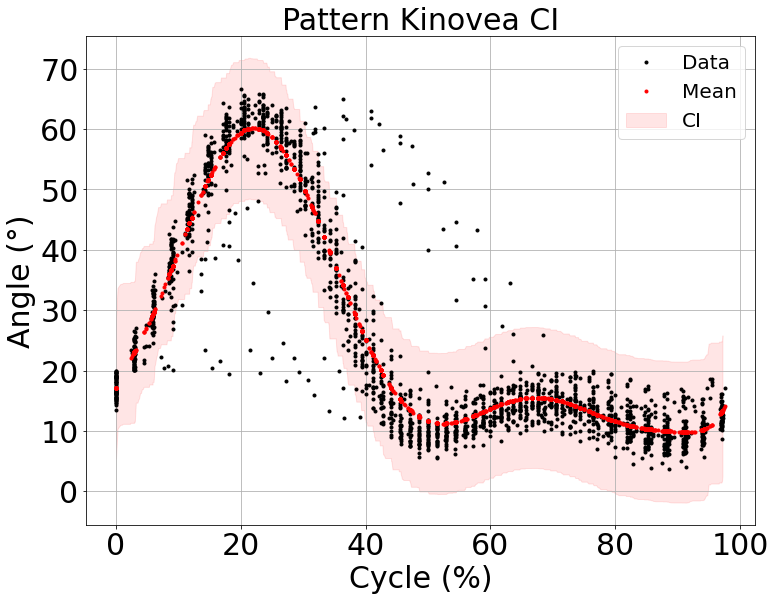

In [19]:
# Kinovea
patternK_IC = pjl.DataProcessing.patternCI(patternK[:,0],
                                           patternK[:,1],
                                           poly_degree = 10,
                                           title = 'Pattern Kinovea CI',
                                           label1 = 'Data',
                                           label2 = 'Mean',
                                           df = False,
                                           plot = True)

## (10) Comparison of data 


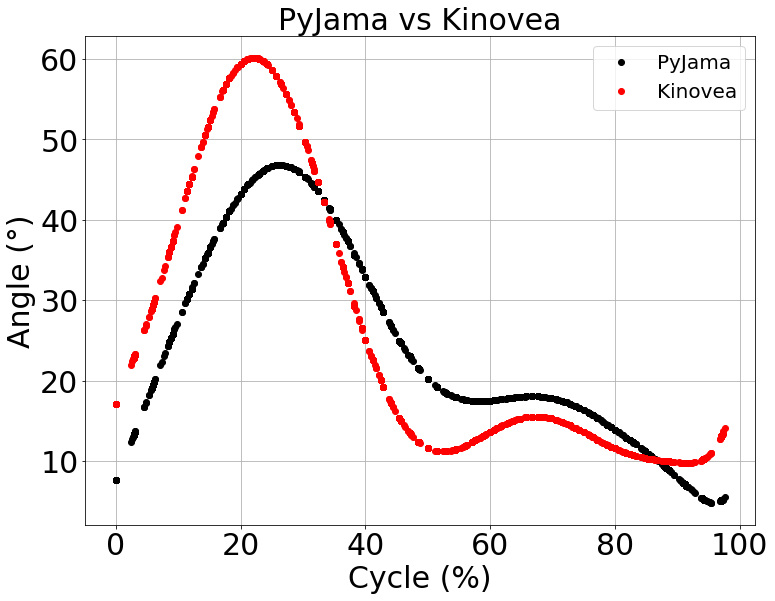

In [20]:
statsX,statsK = pjl.DataProcessing.data_comparison(patternK,
                                                   patternX_IC,
                                                   patternK_IC,
                                                   title = 'PyJama vs Kinovea',
                                                   label1 = 'PyJama',
                                                   label2 = 'Kinovea')